In [8]:
from pathlib import Path

import colorcet as cc
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pyvista as pv
import scipy.spatial as scspatial
from desmin_reconstruction.plotting.lineplots import line_and_bandplot
from desmin_reconstruction.plotting.renderings import (
    render_boundingsquare,
    render_pointcloud,
)
from desmin_reconstruction.preprocessing.bbox import BoundingSquare
from desmin_reconstruction.voronoi import random_uniform_like, VoronoiAnalysis
from hdbscan import HDBSCAN
from sklearn.metrics import calinski_harabasz_score
from tqdm import tqdm


plt.rc("font", size=12)
plt.rc("grid", linestyle="--", color="lightgray")
plt.rc("axes.spines", right=False, top=False)
pv.set_jupyter_backend("static")

COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00"}

datadir = Path("../data/")

## Import and visualize dSTORM raw data

In [2]:
filepath = datadir / "STORM/desmin_alphaactinin_2.5um.csv"
df = pl.read_csv(filepath)
df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])
df = df.filter((pl.col("x") <= 19.0) & (pl.col("y") <= 19.0))
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}


2026-01-30 15:52:01.879 (  82.774s) [    1550028C8740]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


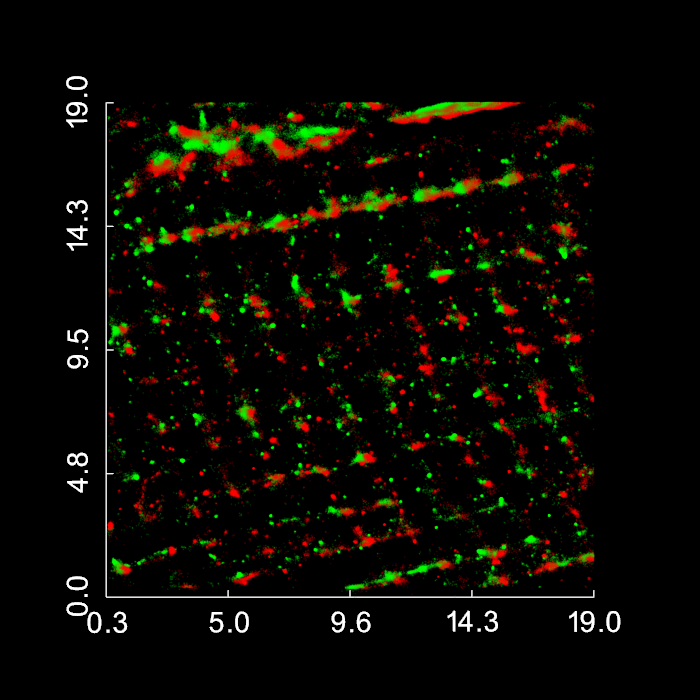

In [3]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()


In [8]:
out = df.partition_by("probe")
voros = [VoronoiAnalysis(o.select(["x", "y", "z"]).to_numpy()) for o in out]
voro_vols = [v.region_volumes for v in voros]

100%|██████████| 123728/123728 [00:34<00:00, 3603.19it/s]


In [9]:
def determine_threshold(localizations, n_trials: int = 10, seed: int = 0):
    rng = np.random.default_rng(seed)
    volumes = []
    for _ in tqdm(range(n_trials)):
        voro_rand = VoronoiAnalysis(random_uniform_like(localizations, rng))
        volumes.append(voro_rand.region_volumes)
    return volumes


voro_vol_rands = [determine_threshold(v.points) for v in voros]

100%|██████████| 10/10 [07:06<00:00, 42.69s/it]


In [10]:
voro_vol_rands_ = [np.stack(v, axis=0) for v in voro_vol_rands]
for v in voro_vol_rands_:
    print(v.shape)

(10, 134248)
(10, 123728)


In [11]:
savepath = datadir / f"results/{filepath.stem}_voronoi_volumes_small.npz"
if not savepath.exists():
    np.savez(
        savepath,
        desmin=voro_vols[0],
        alpha_actinin=voro_vols[1],
        desmin_random=voro_vol_rands_[0],
        alpha_actinin_random=voro_vol_rands_[1],
    )

In [4]:
voronoi_volumes = np.load(
    datadir / "results/desmin_alphaactinin_2.5um_voronoi_volumes_small.npz"
)

In [5]:
def histogram_fixed_binsize(values, bin_size, min_value=0.0, max_value=np.inf):
    values_valid = values[~np.isnan(values)]
    values_valid = np.clip(values_valid, min_value, max_value)
    bins = np.arange(min_value, max_value, bin_size)
    return np.histogram(values_valid, bins)


def internal_division_point(x1, x2, y1, y2):
    return (y1 * x2 + y2 * x1) / (y1 + y2)


def find_crossing_points(x, y1, y2):
    y_diff = y1 - y2
    x_exact_crossing = x[np.flatnonzero(y_diff == 0)]

    ind_sign_change = np.flatnonzero(y_diff[:-1] * y_diff[1:] <= 0)
    print(ind_sign_change)
    x_interped_crossing = internal_division_point(
        x[ind_sign_change],
        x[ind_sign_change + 1],
        y_diff[ind_sign_change],
        -y_diff[ind_sign_change + 1],
    )
    x_crossing = np.concatenate((x_exact_crossing, x_interped_crossing), axis=0)
    return np.sort(x_crossing)

[13]
[14]


Text(0.5, 0.01, 'Voronoi cell volume (μm³)')

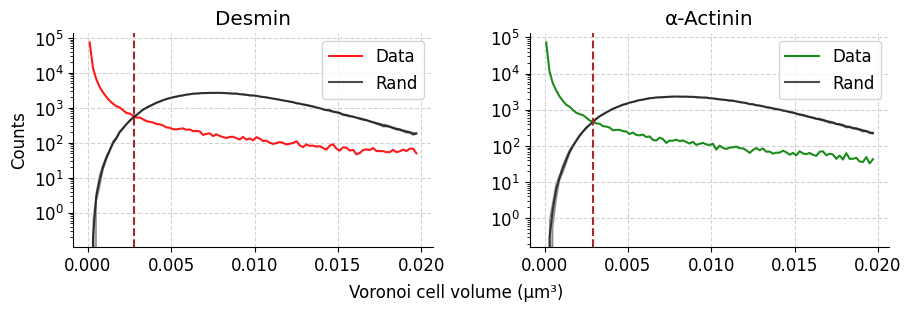

In [6]:
vol_thresholds = []

fig, axes = plt.subplots(
    1, 2, figsize=(9, 3), constrained_layout=True, gridspec_kw={"wspace": 0.1}
)
names = ("desmin", "alpha_actinin")
color_dict = {"desmin": "red", "alpha_actinin": "green"}
title_dict = {"desmin": "Desmin", "alpha_actinin": "α-Actinin"}
for ax, n in zip(axes, names):
    counts, bin_edges = histogram_fixed_binsize(
        voronoi_volumes[n], bin_size=2e-4, max_value=2e-2
    )
    counts_rand = np.stack(
        [
            histogram_fixed_binsize(vol, bin_size=2e-4, max_value=2e-2)[0]
            for vol in voronoi_volumes[f"{n}_random"]
        ],
        axis=0,
    )
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.plot(bin_centers, counts, alpha=0.9, color=color_dict[n], label="Data")
    counts_rand_mean = np.mean(counts_rand, axis=0)
    ax = line_and_bandplot(
        ax,
        bin_centers,
        counts_rand_mean,
        np.std(counts_rand, axis=0),
        color="black",
        alpha=0.7,
        label="Rand",
    )
    ax.set_yscale("log")

    vol_thres = find_crossing_points(bin_centers, counts, counts_rand_mean)[0]
    vol_thresholds.append(vol_thres)
    ax.axvline(
        x=vol_thres,
        linestyle="--",
        color="brown",
    )
    ax.legend()
    ax.grid(ls="--", color="lightgray")
    ax.set_title(title_dict[n])
axes[0].set_ylabel("Counts")
fig.supxlabel("Voronoi cell volume (μm³)", fontsize="medium")

In [7]:
vol_thresholds

[np.float64(0.0027874921433060965), np.float64(0.0029135961930659418)]

In [9]:
coeff = 1.0
out = df.partition_by("probe")
df_filtered = [
    pl.concat(
        (
            out[i],
            pl.DataFrame({"voronoi_volume": voronoi_volumes[n]}),
        ),
        how="horizontal",
    ).filter(pl.col("voronoi_volume") <= coeff * vol_thresholds[i])
    for i, n in enumerate(("desmin", "alpha_actinin"))
]
df_filtered_total = pl.concat(df_filtered)

In [10]:
savepath_filtered = datadir / f"results/{filepath.stem}_filtered_small.csv"
if not savepath_filtered.exists():
    df_filtered_total.write_csv(savepath_filtered)

## Import filtered data

In [22]:
filepath = datadir / "results/desmin_alphaactinin_2.5um_filtered_small.csv"
df = pl.read_csv(filepath)
# df = df.with_columns(*[pl.col(i) / 1000 for i in ("x", "y", "z")])
df = df.with_columns(*[pl.col(i) - pl.col(i).min() for i in ("x", "y", "z")])

points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}


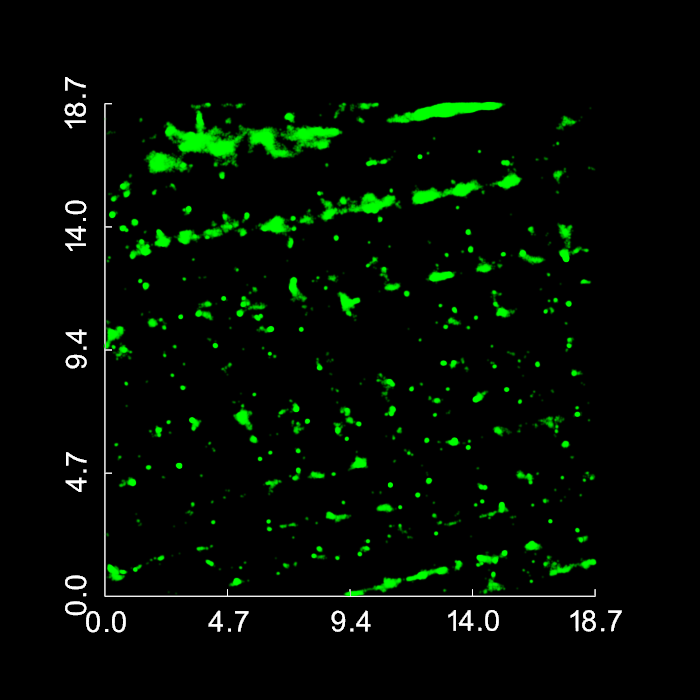

In [23]:
show_rect = False
proteins = (
    # "desmin",
    "actinin",
)
p = pv.Plotter(notebook=True, window_size=(700, 700))

for name in proteins:
    p = render_pointcloud(
        p, points[name], color=COLOR_DICT[name], opacity=0.2, point_size=1.5
    )

if show_rect:
    bbox = BoundingSquare(0.5, 2, side=10)
    p = render_boundingsquare(p, bbox, line_width=2.0, color="white", z_height=10.0)

    p.enable_parallel_projection()
    p.view_xy()

p.set_background(color="black")
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
p.save_graphic("../figures/fig_1/1b/actinin.svg")


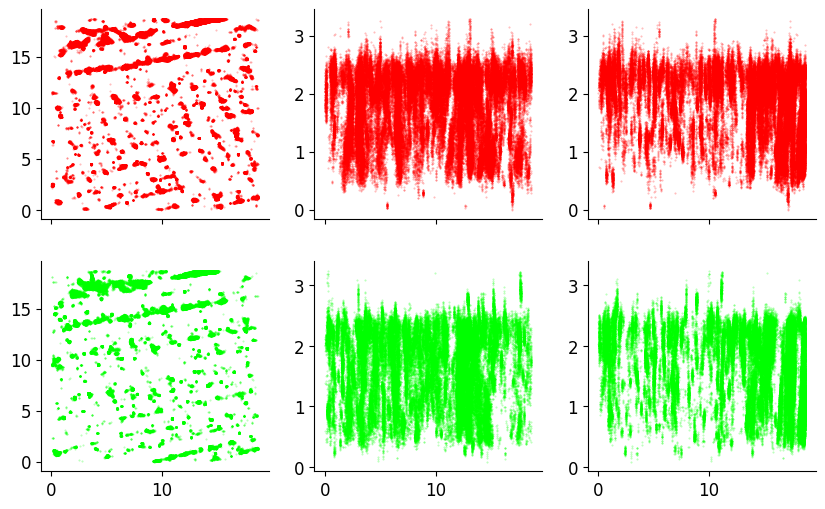

In [4]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharex=True)
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points[protein][:, ax1],
            points[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

## Plot ROI

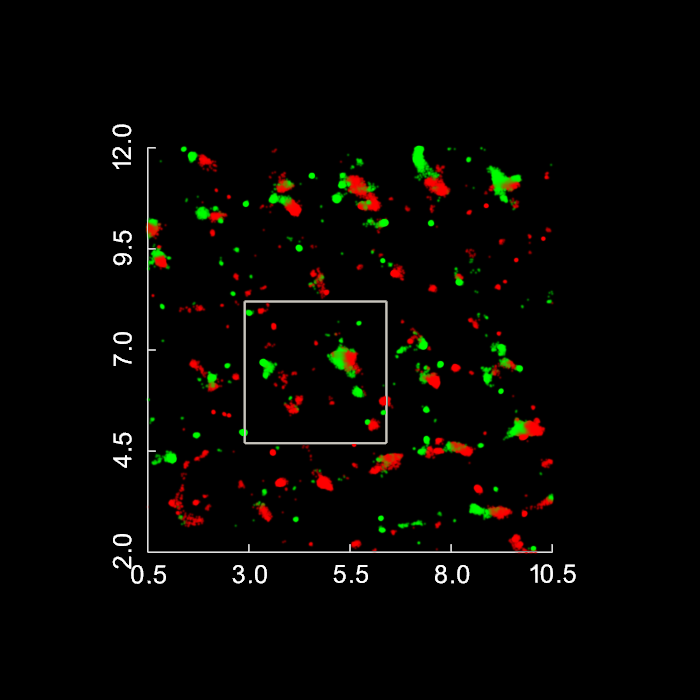

In [38]:
show_rect = True
proteins = (
    "desmin",
    "actinin",
)
p = pv.Plotter(notebook=True, window_size=(700, 700))

bbox = BoundingSquare(0.5, 2, side=10)
points_roi = {k: filter_bounded(v, bbox) for k, v in points.items()}
for name in proteins:
    p = render_pointcloud(
        p, points_roi[name], color=COLOR_DICT[name], opacity=0.4, point_size=2.0
    )

if show_rect:
    bbox2 = BoundingSquare(2.9, 4.7, side=3.5)
    p = render_boundingsquare(p, bbox2, line_width=2.0, color="white", z_height=10.0)

    p.enable_parallel_projection()
    p.view_xy()

p.set_background(color="black")
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
p.save_graphic("../figures/fig_1/1b/roi.svg")


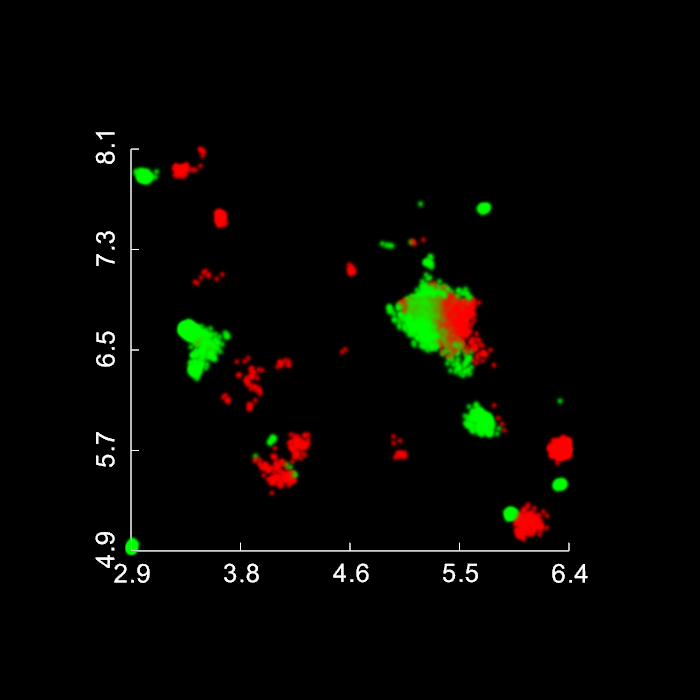

In [44]:
proteins = (
    "desmin",
    "actinin",
)
p = pv.Plotter(notebook=True, window_size=(700, 700))

bbox2 = BoundingSquare(2.9, 4.7, side=3.5)
points_roi2 = {k: filter_bounded(v, bbox2) for k, v in points_roi.items()}
for name in proteins:
    p = render_pointcloud(
        p, points_roi2[name], color=COLOR_DICT[name], opacity=0.7, point_size=4.0
    )

p.set_background(color="black")
p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
p.save_graphic("../figures/fig_1/1b/roi2.svg")


## Align volume

In [25]:
import warnings

from desmin_reconstruction.preprocessing.storm import align_patch


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-0.5, 0.5, 0.001),
        rotation_sweep_values=np.arange(-30, -25, 0.5),
        min_cluster_size=1000,
        min_samples=5,
    )

100%|██████████| 10/10 [00:24<00:00,  2.46s/it]


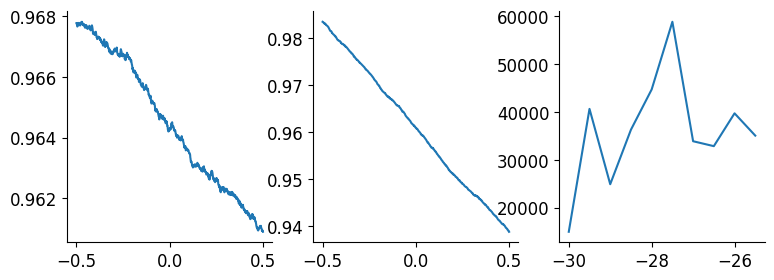

In [26]:
fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

In [27]:
coords_new = transform_fn(df.select(["x", "y", "z"]).to_numpy())
df_aligned = df.with_columns(pl.from_numpy(coords_new, schema=["x", "y", "z"]))

In [28]:
points_final = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df_aligned.partition_by("probe"))
}

In [4]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points_final.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)
p.show()
# p.save_graphic("../figures/supp_fig_1b/desmin.svg")

NameError: name 'points_final' is not defined

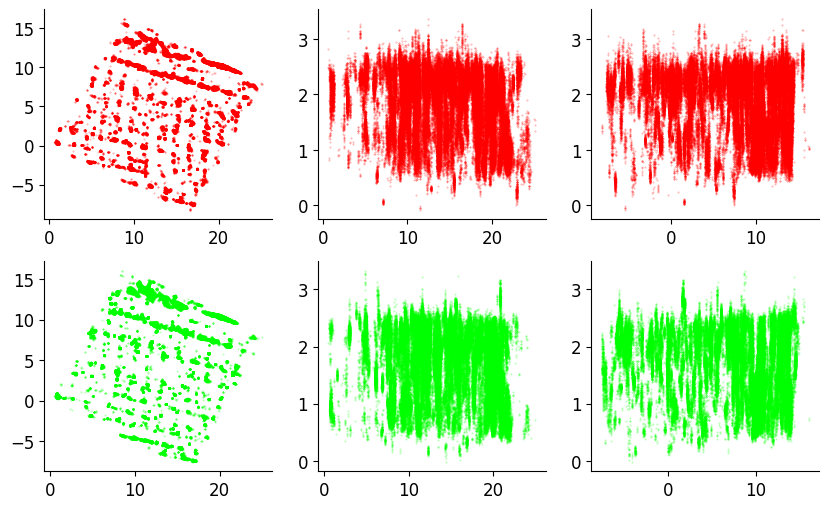

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, protein in enumerate(("desmin", "actinin")):
    for j, (ax1, ax2) in enumerate(((0, 1), (0, 2), (1, 2))):
        axes[i, j].scatter(
            points_final[protein][:, ax1],
            points_final[protein][:, ax2],
            c=COLOR_DICT[protein],
            **scatter_kwargs,
        )

In [ ]:
# df_aligned.write_csv("../data/results/desmin_alphaactinin_2.5um_small_aligned.csv")

## Choose 4um x 4um regions of interest

In [9]:
df = pl.read_csv("../data/results/desmin_alphaactinin_2.5um_small_aligned.csv")
points = {
    name: df_.select(["x", "y", "z"]).to_numpy()
    for name, df_ in zip(("desmin", "actinin"), df.partition_by("probe"))
}

In [10]:
x0s = (18.5, 16.5, 14.5, 14.5, 12.5, 10.5, 8.5, 6.5, 4.5, 2.5, 0.5, 4.5)
y0s = (2.0, -2.0, -6.0, 2.0, -2.0, 2.0, -2.0, 2.0, -2.0, 2.0, -2.0, 6.0)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

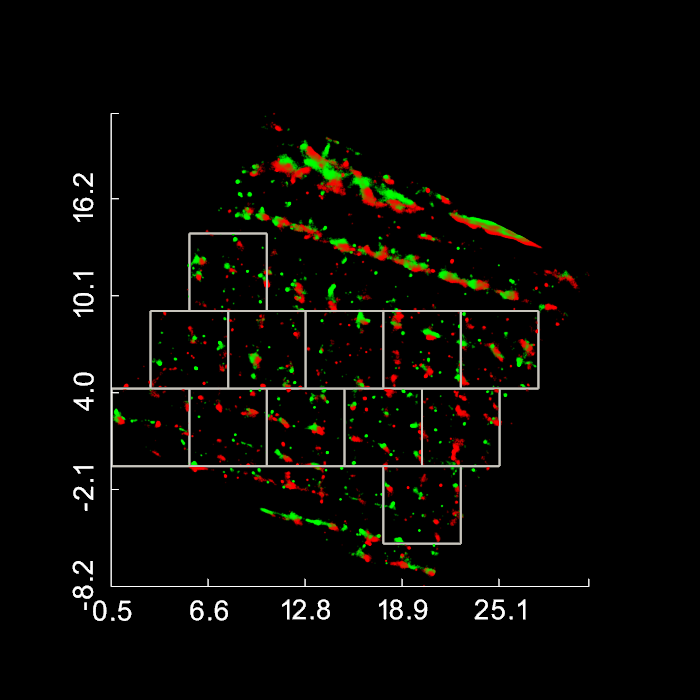

In [12]:
p = pv.Plotter(notebook=True, window_size=(700, 700))
for name, coords in points.items():
    p = render_pointcloud(p, coords, color=COLOR_DICT[name], opacity=0.2)

for bbox in bboxes:
    p = render_boundingsquare(p, bbox, line_width=2.0, color="white", z_height=10.0)

p.enable_parallel_projection()
p.view_xy()

p.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
    show_zaxis=False,
    xtitle="",
    ytitle="",
)


p.show()
p.save_graphic("../figures/supp_fig_2/2b.svg")

ColumnNotFoundError: "voronoi_volume" not found

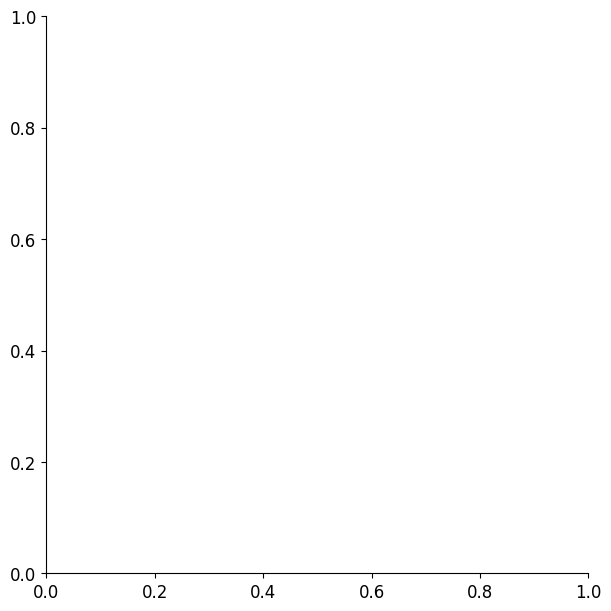

In [ ]:
scatter_kwargs = {"alpha": 0.3, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 2.5}

fig, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    constrained_layout=True,
)
for i, cmap in zip((0, 1), (cc.cm.kr_r, cc.cm.kg_r)):
    ax.scatter(
        out[i]["x"],
        out[i]["y"],
        c=np.log10(1 / out[i]["voronoi_volume"]),
        cmap=cmap,
        **scatter_kwargs,
    )
ax.axis("equal")
ax.set_ylim((-0.4, 38.1))
ax.set_xticks(np.arange(0, 40, 6))
ax.set_yticks(np.arange(0, 40, 6))

x_line = np.linspace(0, 40, 1000)
ax.plot(x_line, (5 / 20) * x_line + 11.5, "--", color="black", linewidth=2.0)
ax.plot(x_line, (5 / 20) * x_line - 1.2, "--", color="black", linewidth=2.0)

Text(0.5, 0.01, 'x (μm)')

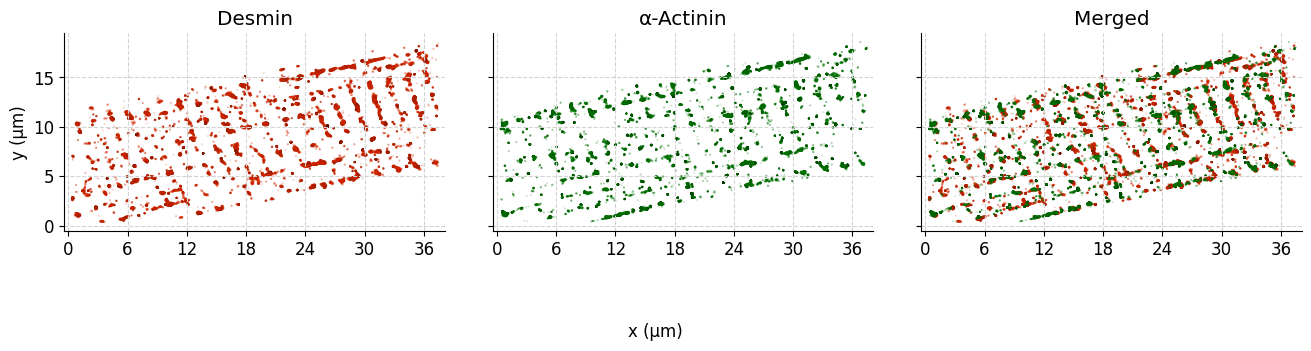

In [66]:
df_roi = df.filter(pl.col("y") >= pl.col("x") / 5 - 1.5).filter(
    pl.col("y") <= pl.col("x") / 5 + 11.5
)
out = df_roi.partition_by("probe")

scatter_kwargs = {"alpha": 0.2, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 2.5}

fig, axes = plt.subplots(
    1,
    3,
    figsize=(13, 4),
    sharey=True,
    constrained_layout=True,
    gridspec_kw={"wspace": 0.1},
)
for i in (0, 2):
    axes[i].scatter(
        out[0]["x"],
        out[0]["y"],
        c=np.log10(1 / out[0]["voronoi_volume"]),
        cmap=cc.cm.kr_r,
        **scatter_kwargs,
    )
for i in (1, 2):
    axes[i].scatter(
        out[1]["x"],
        out[1]["y"],
        c=np.log10(1 / out[1]["voronoi_volume"]),
        cmap=cc.cm.kg_r,
        **scatter_kwargs,
    )

for ax, title in zip(axes, ("Desmin", "α-Actinin", "Merged")):
    ax.set_aspect("equal", adjustable="box")
    # ax.set_xlim((-0.2, 19.3))
    ax.set_xlim((-0.4, 38.1))
    ax.set_xticks(np.arange(0, 40, 6))
    ax.set_title(title)
    ax.grid(ls="--", color="lightgray")
axes[0].set_ylabel("y (μm)")
fig.supxlabel("x (μm)", fontsize="medium")

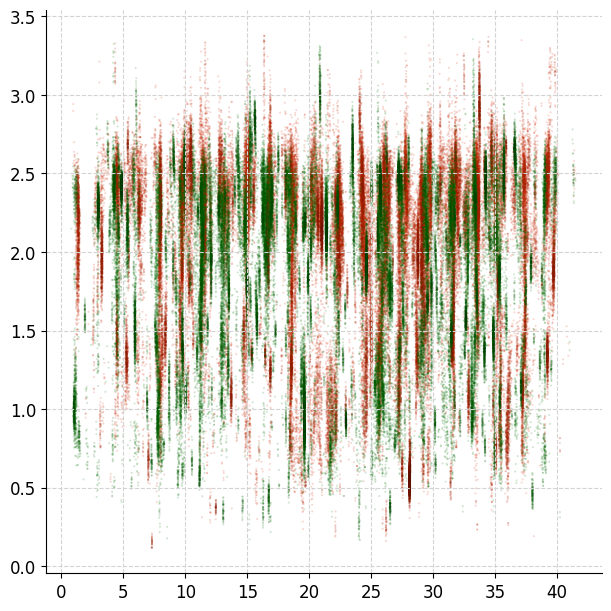

In [67]:
scatter_kwargs = {"alpha": 0.2, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 2.5}
points = [o.select(["x", "y", "z"]).to_numpy() for o in out]

theta = 20.847457627118644
r = scspatial.transform.Rotation.from_rotvec(theta * np.array([0, 0, -1]), degrees=True)
points_rotated = [r.apply(p) for p in points]

fig, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    constrained_layout=True,
)
for i, cmap in zip((0, 1), (cc.cm.kr_r, cc.cm.kg_r)):
    ax.scatter(
        points_rotated[i][:, 0],
        points_rotated[i][:, 2],
        c=np.log10(1 / out[i]["voronoi_volume"]),
        cmap=cmap,
        **scatter_kwargs,
    )


ax.grid(ls="--", color="lightgray")


In [93]:
clusterer = HDBSCAN(
    min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=0.02
)
clusterer.fit(points_rotated[1][:, np.array([0])])


HDBSCAN(cluster_selection_epsilon=0.02, min_cluster_size=1000, min_samples=20)

In [94]:
def plot(X, labels, probabilities=None, parameters=None, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    cmap = plt.get_cmap("cet_glasbey_light")
    colors = [cmap(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        ax.scatter(
            *X[labels == k].T,
            s=1 if k == -1 else 2,
            marker=".",
            facecolor=tuple(col),
            edgecolor=None,
            alpha=0.7,
        )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    title = f"Estimated number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

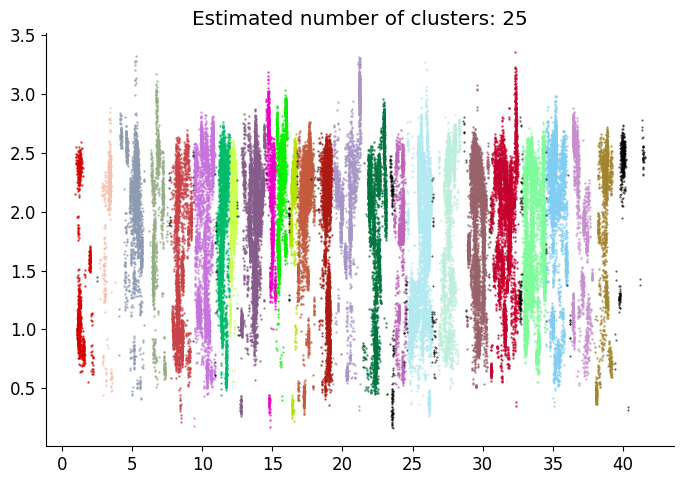

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[1][:, np.array([0, 2])], clusterer.labels_, ax=ax)

In [111]:
clusterer = HDBSCAN(
    min_cluster_size=1000, min_samples=20, cluster_selection_epsilon=0.02
)
metrics = []
points_actinin = points[1]

r = scspatial.transform.Rotation.from_rotvec(theta * np.array([0, 0, -1]), degrees=True)


angles = np.linspace(10, 25, 50)
for theta in tqdm(angles):
    r = scspatial.transform.Rotation.from_rotvec(
        theta * np.array([0, 0, -1]), degrees=True
    )
    pts_actinin_rot = r.apply(points_actinin)
    clusterer.fit(pts_actinin_rot[:, np.array([0, 2])])

    metrics.append(
        calinski_harabasz_score(pts_actinin_rot[:, np.array([0, 2])], clusterer.labels_)
    )

100%|██████████| 50/50 [01:23<00:00,  1.68s/it]


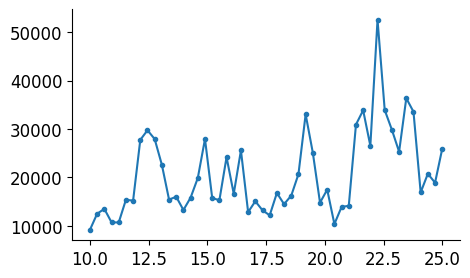

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(angles, np.array(metrics), ".-")

In [113]:
angles[np.argmax(np.array(metrics))]

np.float64(22.244897959183675)

In [114]:
r = scspatial.transform.Rotation.from_rotvec(
    angles[np.argmax(np.array(metrics))] * np.array([0, 0, -1]), degrees=True
)
points_rotated = [r.apply(p) for p in points]

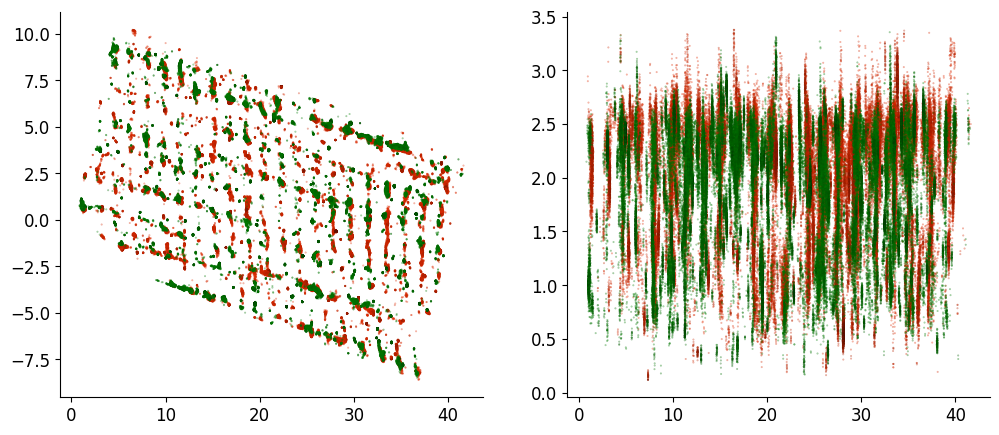

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, cmap in zip((0, 1), (cc.cm.kr_r, cc.cm.kg_r)):
    axes[0].scatter(
        points_rotated[i][:, 0],
        points_rotated[i][:, 1],
        c=np.log10(1 / out[i]["voronoi_volume"]),
        cmap=cmap,
        **scatter_kwargs,
    )
    axes[1].scatter(
        points_rotated[i][:, 0],
        points_rotated[i][:, 2],
        c=np.log10(1 / out[i]["voronoi_volume"]),
        cmap=cmap,
        **scatter_kwargs,
    )

# axes[0].axis("equal")

In [132]:
clusterer = HDBSCAN(
    min_cluster_size=1000, min_samples=100, cluster_selection_epsilon=0.02
)
clusterer.fit(points_rotated[1][:, np.array([0, 2])])


HDBSCAN(cluster_selection_epsilon=0.02, min_cluster_size=1000, min_samples=100)

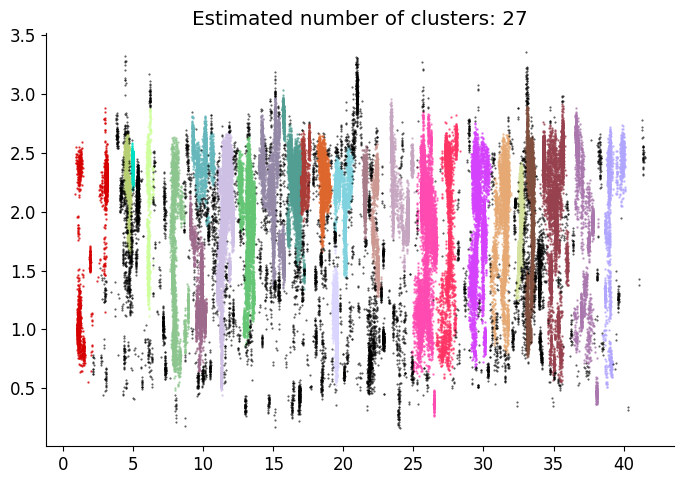

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[1][:, np.array([0, 2])], clusterer.labels_, ax=ax)

(array([7.900e+01, 7.620e+02, 1.230e+02, 6.700e+01, 1.000e+00, 9.500e+01,
        1.900e+01, 1.000e+00, 1.500e+01, 4.100e+01, 4.760e+02, 5.390e+02,
        1.000e+00, 1.000e+00, 6.100e+01, 3.300e+01, 1.350e+02, 6.260e+02,
        8.220e+02, 4.980e+02, 1.709e+03, 3.280e+02, 3.420e+02, 2.100e+01,
        9.000e+00, 9.490e+02, 2.030e+02, 8.000e+01, 1.000e+01, 1.400e+01,
        6.000e+01, 2.220e+02, 1.000e+00, 1.180e+02, 1.387e+03, 5.540e+02,
        1.760e+02, 1.040e+02, 1.550e+02, 2.050e+02, 1.580e+02, 4.520e+02,
        4.310e+02, 4.850e+02, 8.750e+02, 1.051e+03, 1.480e+02, 1.870e+02,
        2.460e+02, 1.420e+02, 4.640e+02, 1.632e+03, 1.776e+03, 8.190e+02,
        6.140e+02, 5.140e+02, 5.200e+01, 3.410e+02, 3.070e+02, 3.190e+02,
        1.382e+03, 6.470e+02, 9.530e+02, 2.000e+01, 1.380e+02, 5.060e+02,
        2.250e+02, 1.790e+02, 4.340e+02, 1.260e+03, 5.180e+02, 3.670e+02,
        2.790e+02, 6.330e+02, 2.910e+02, 6.750e+02, 7.320e+02, 9.080e+02,
        7.600e+02, 7.200e+02, 6.510e+0

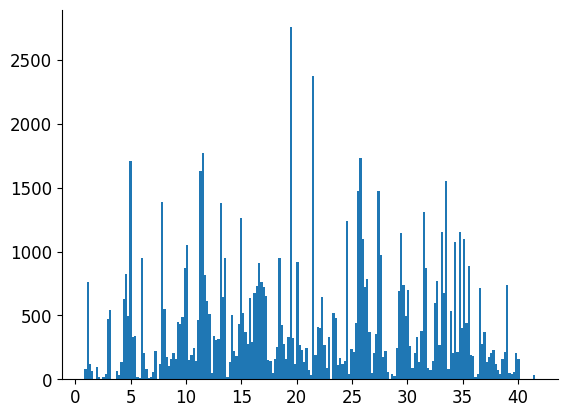

In [121]:
plt.hist(points_rotated[1][:, 0], bins=200)

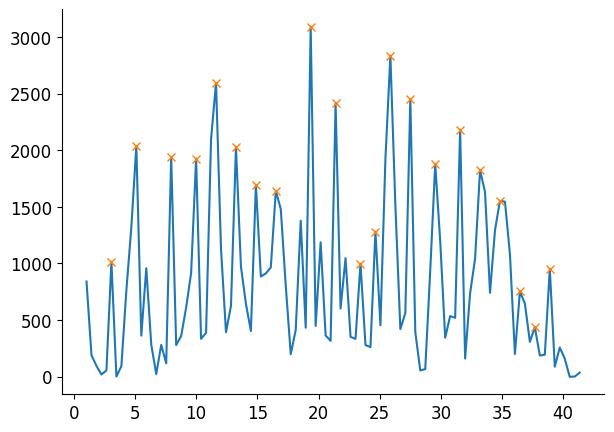

In [ ]:
import scipy


counts, bin_edges = np.histogram(points_rotated[1][:, 0], bins=200)
bin_pos = 0.5 * (bin_edges[:-1] + bin_edges[1:])
# Find peaks with separation more than the known sarcomere length (~1.6um)
peaks, _ = scipy.signal.find_peaks(counts, distance=1.0 / (bin_pos[1] - bin_pos[0]))

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(bin_pos, counts)
ax.plot(bin_pos[peaks], counts[peaks], "x")

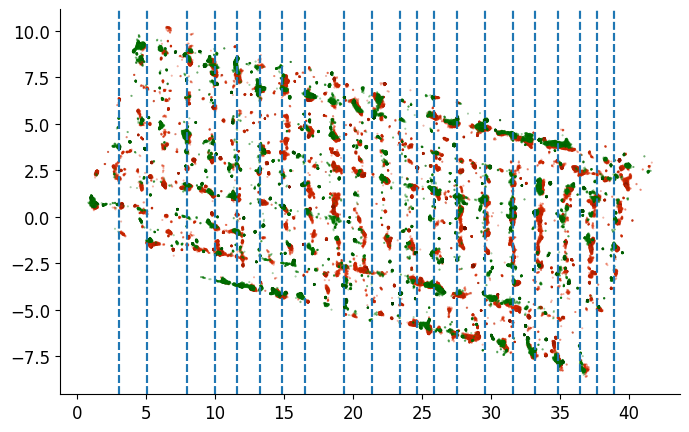

In [123]:
scatter_kwargs = {"alpha": 0.4, "s": 0.2, "edgecolor": None, "vmax": 9, "vmin": 2.5}

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for i, cmap in zip((0, 1), (cc.cm.kr_r, cc.cm.kg_r)):
    ax.scatter(
        points_rotated[i][:, 0],
        points_rotated[i][:, 1],
        c=np.log10(1 / out[i]["voronoi_volume"]),
        cmap=cmap,
        **scatter_kwargs,
    )
    for x in bin_pos[peaks]:
        ax.axvline(x=x, ls="--")

# axes[0].axis("equal")

In [41]:
actinin_distances = np.min(
    np.abs(points_rotated[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)
desmin_distances = np.min(
    np.abs(points_rotated_desmin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

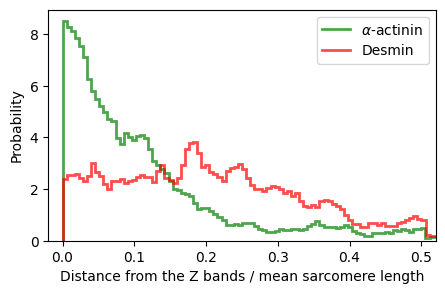

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.stairs(
    *np.histogram(
        actinin_distances / mean_sarcomere_length,
        bins=100,
        density=True,
    ),
    alpha=0.7,
    linewidth=2.0,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.stairs(
    *np.histogram(
        desmin_distances / mean_sarcomere_length,
        bins=100,
        density=True,
    ),
    alpha=0.7,
    linewidth=2.0,
    color="red",
    label="Desmin",
)
ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Probability")
ax.set_xlim((-0.02, 0.52))
ax.legend()

In [62]:
clusterer = HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=50)
clusterer.fit(points_rotated)

HDBSCAN(cluster_selection_epsilon=50, min_samples=1)

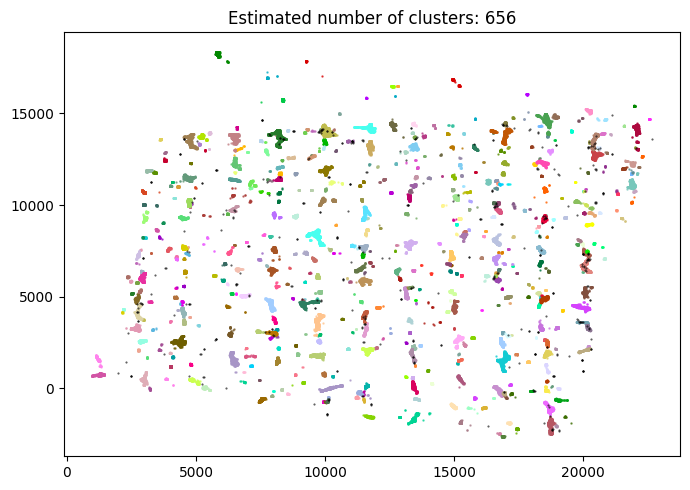

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated[:, np.array([0, 1])], clusterer.labels_, ax=ax)

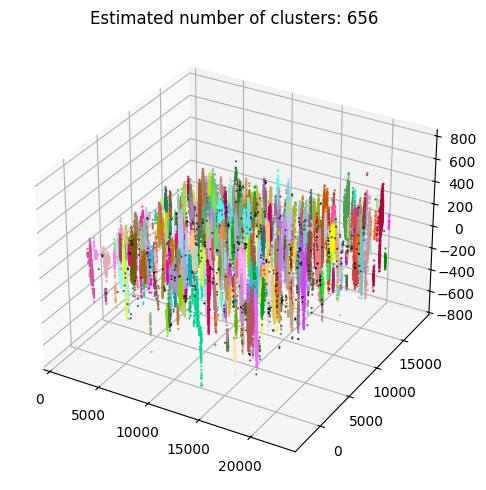

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5), subplot_kw={"projection": "3d"})
plot(points_rotated, clusterer.labels_, ax=ax)

In [69]:
cluster_vol_actinin = []
cluster_cm_actinin = []
unique_labels = set(clusterer.labels_)
for lb in tqdm(unique_labels):
    if lb == -1:
        continue
    cluster_points = points_rotated[clusterer.labels_ == lb]
    cluster_hull = scspatial.ConvexHull(cluster_points)
    cluster_vol_actinin.append(cluster_hull.volume)
    cm = np.mean(cluster_hull.points[cluster_hull.vertices, :], axis=0)
    cluster_cm_actinin.append(cm)
cluster_vol_actinin = np.asarray(cluster_vol_actinin)
cluster_cm_actinin = np.stack(cluster_cm_actinin, axis=0)

100%|██████████| 657/657 [00:00<00:00, 1671.09it/s]


In [71]:
cluster_actinin_distances = np.min(
    np.abs(cluster_cm_actinin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

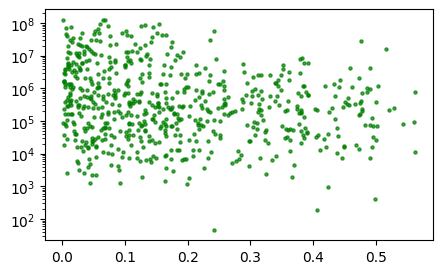

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.scatter(
    cluster_actinin_distances / mean_sarcomere_length,
    cluster_vol_actinin,
    s=5,
    alpha=0.7,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.set_yscale("log", base=10)

In [83]:
clusterer = HDBSCAN(min_cluster_size=5, min_samples=1, cluster_selection_epsilon=30)
clusterer.fit(points_rotated_desmin)

HDBSCAN(cluster_selection_epsilon=30, min_samples=1)

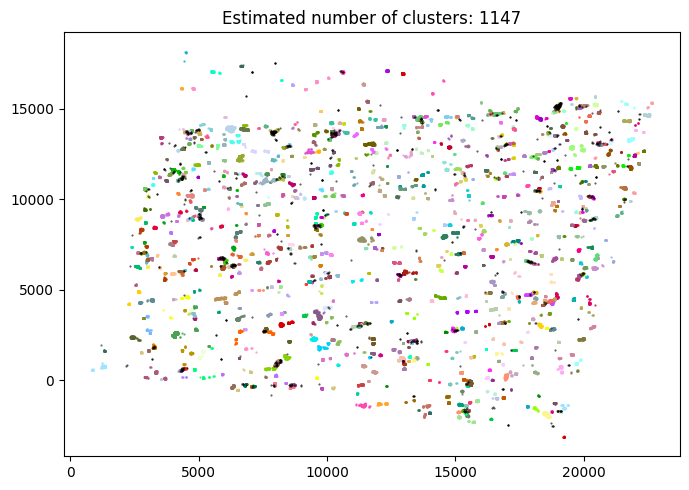

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plot(points_rotated_desmin[:, np.array([0, 1])], clusterer.labels_, ax=ax)

In [86]:
cluster_vol_desmin = []
cluster_cm_desmin = []
unique_labels = set(clusterer.labels_)
for lb in tqdm(unique_labels):
    if lb == -1:
        continue
    try:
        cluster_points = points_rotated_desmin[clusterer.labels_ == lb]
        cluster_hull = scspatial.ConvexHull(cluster_points)
        cluster_vol_desmin.append(cluster_hull.volume)
        cm = np.mean(cluster_hull.points[cluster_hull.vertices, :], axis=0)
        cluster_cm_desmin.append(cm)
    except scspatial.QhullError:
        continue
cluster_vol_desmin = np.asarray(cluster_vol_desmin)
cluster_cm_desmin = np.stack(cluster_cm_desmin, axis=0)

100%|██████████| 1148/1148 [00:00<00:00, 3066.35it/s]


In [87]:
cluster_desmin_distances = np.min(
    np.abs(cluster_cm_desmin[:, 0] - np.expand_dims(bin_pos[peaks], axis=1)), axis=0
)

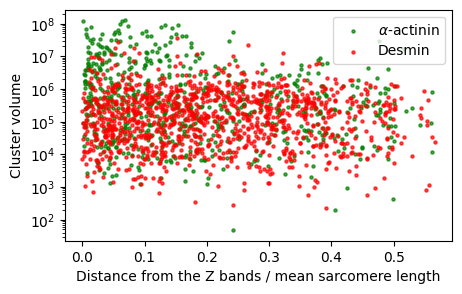

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
mean_sarcomere_length = np.mean(np.diff(bin_pos[peaks]))
ax.scatter(
    cluster_actinin_distances / mean_sarcomere_length,
    cluster_vol_actinin,
    s=5,
    alpha=0.7,
    color="green",
    label=r"$\alpha$-actinin",
)
ax.scatter(
    cluster_desmin_distances / mean_sarcomere_length,
    cluster_vol_desmin,
    s=5,
    alpha=0.7,
    color="red",
    label=r"Desmin",
)
ax.set_yscale("log", base=10)
ax.set_xlabel("Distance from the Z bands / mean sarcomere length")
ax.set_ylabel("Cluster volume")
ax.legend()

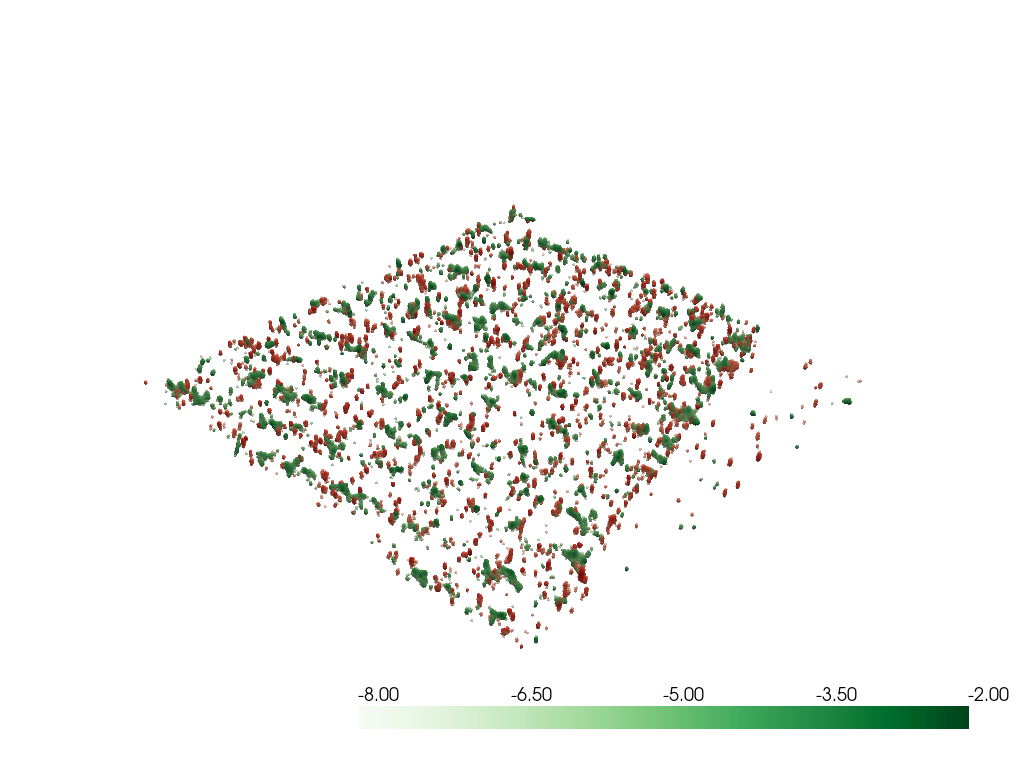

In [ ]:
p = pv.Plotter()
point_cloud_desmin = pv.PolyData(points_desmin_filtered)
point_cloud_actinin = pv.PolyData(points_actinin_filtered)
p.add_mesh(
    point_cloud_desmin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_desmin),
    cmap="Reds",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
p.add_mesh(
    point_cloud_actinin,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vols_actinin),
    cmap="Greens",
    show_edges=False,
    opacity=0.5,
    clim=(-8, -2),
)
# p.camera_position = "xy"
p.show()

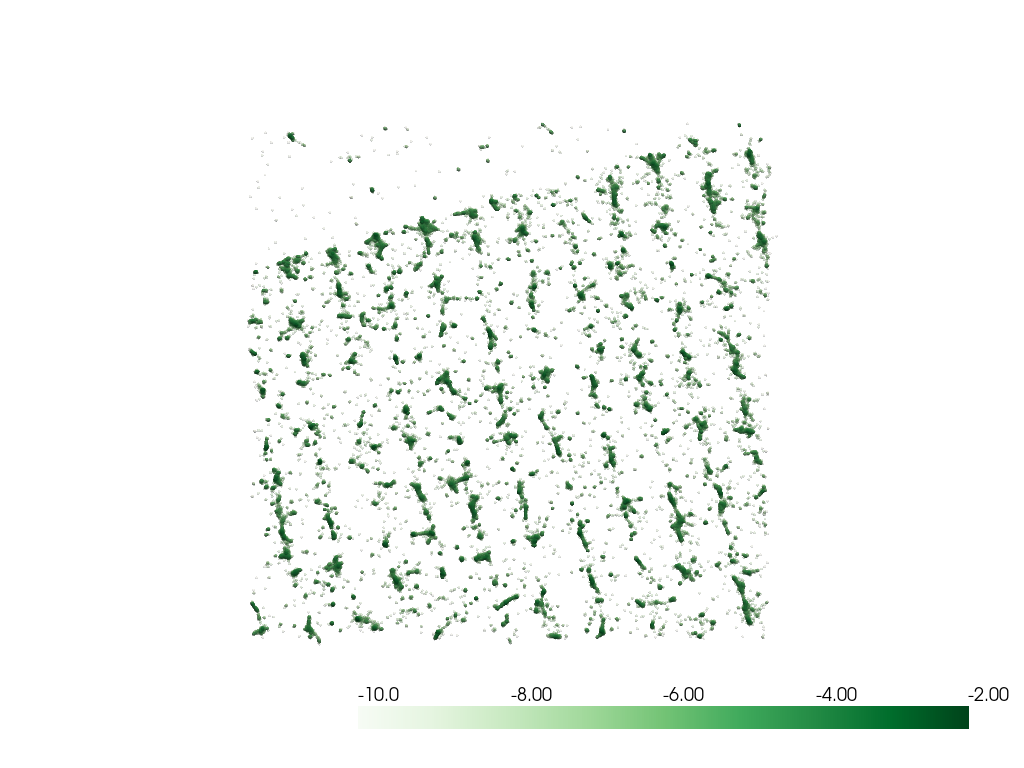

In [55]:
p = pv.Plotter()
point_cloud = pv.PolyData(points)
p.add_mesh(
    point_cloud,
    render_points_as_spheres=True,
    point_size=3,
    scalars=np.log10(1 / vol + 1e-18),
    cmap="Greens",
    clim=(-10, -2),
    show_edges=False,
    opacity=0.3,
)
p.camera_position = "xy"
p.show()

In [84]:
points.shape

(134279, 3)

In [85]:
vol.shape

(134279,)

In [86]:
grids = np.meshgrid(*[np.arange(b_min[i], b_max[i], 20) for i in range(len(b_min))])
grids[0].shape

(952, 959, 30)

In [87]:
grids = np.stack(grids, axis=-1)

In [88]:
grids.shape

(952, 959, 30, 3)

In [ ]:
import scipy.interpolate as scinterpolate


interpolator = scinterpolate.RBFInterpolator(points, 1 / vol + 1e-18, neighbors=500)
interp_results = scinterpolate.griddata(points, 1 / vol + 1e-18, grids.reshape(-1, 3))

In [90]:
out = interp_results.reshape(*grids.shape[:-1])

In [91]:
density = 1 / vol
np.min(density[density > 0])

np.float64(2.129564936558756e-18)

(array([3.041800e+04, 8.200000e+01, 1.140000e+02, 1.520000e+02,
        2.060000e+02, 2.960000e+02, 4.300000e+02, 6.410000e+02,
        8.840000e+02, 1.213000e+03, 1.686000e+03, 2.197000e+03,
        2.750000e+03, 3.145000e+03, 3.129000e+03, 2.468000e+03,
        1.807000e+03, 2.395000e+03, 3.382000e+03, 4.567000e+03,
        5.945000e+03, 8.131000e+03, 1.086600e+04, 1.252100e+04,
        1.437100e+04, 1.506100e+04, 1.777500e+04, 2.446100e+04,
        3.006100e+04, 3.458600e+04, 4.029300e+04, 4.442000e+04,
        4.963100e+04, 4.889600e+04, 4.646800e+04, 5.107800e+04,
        6.487800e+04, 7.281300e+04, 7.079000e+04, 6.911000e+04,
        9.101900e+04, 1.141700e+05, 1.299290e+05, 1.273580e+05,
        1.208600e+05, 1.127110e+05, 1.245160e+05, 1.574150e+05,
        1.775980e+05, 2.311830e+05, 2.651020e+05, 3.272720e+05,
        3.980720e+05, 4.649030e+05, 5.061350e+05, 5.567360e+05,
        6.299040e+05, 7.890790e+05, 9.457690e+05, 1.129197e+06,
        1.362705e+06, 1.599159e+06, 1.78

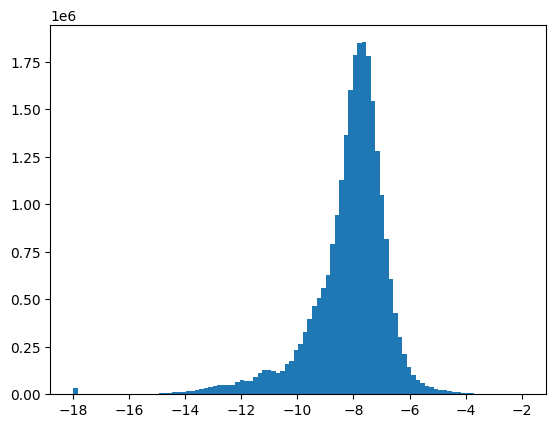

In [92]:
plt.hist(np.log10(interp_results), bins=100)

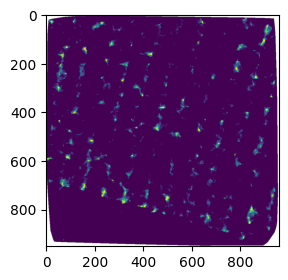

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.imshow(
    np.log10(out[:, :, 10]),
    vmin=np.log10(1 / 0.6e6) - 1,
    vmax=np.log10(1 / 0.6e6) + 1,
)

In [89]:
np.log10(1 / 0.6e6)

np.float64(-5.778151250383644)

/tmp/ipykernel_850234/1718147273.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.hist(np.log10(interp_results).flatten(), bins=100)


ValueError: supplied range of [-inf, -2.31724829161289] is not finite

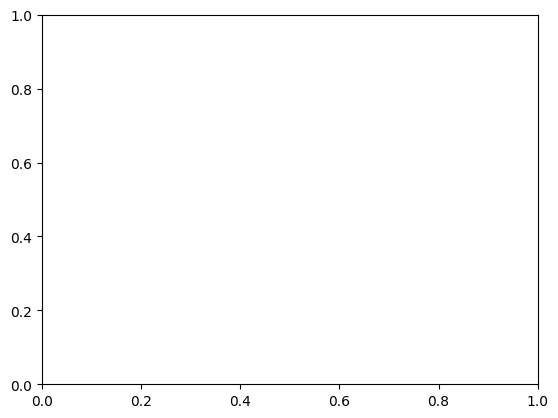

In [34]:
plt.hist(np.log10(interp_results).flatten(), bins=100)